In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F

import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile
import copy


In [2]:
def create_mnist_data(class_splits, split_index, csv_file="mnist.csv", image_shape=(1, 28, 28)):
    df = pd.read_csv(csv_file)
    all_classes = sorted(df['label'].unique())
    start_class = sum(class_splits[:split_index])
    end_class = start_class + class_splits[split_index]
    valid_classes = all_classes[start_class:end_class]

    filtered_df = df[df['label'].isin(valid_classes)]
    X = filtered_df.drop(columns=['label']).values
    y = filtered_df['label'].values
    label_mapping = {cls: i for i, cls in enumerate(valid_classes)}
    y = np.array([label_mapping[label] for label in y])

    X = torch.tensor(X / 255.0, dtype=torch.float32).view(-1, *image_shape)
    y = torch.tensor(y, dtype=torch.long)

    return TensorDataset(X, y)

In [3]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, 2, 2)
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, 2, 2)
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x



In [4]:
def train_model(model, data_loader, criterion, optimizer, epochs, device):
    """
    Trains a given model.
    """
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        with tqdm(total=len(data_loader), desc=f"Epoch {epoch + 1}/{epochs}", unit="batch") as pbar:
            for X_batch, y_batch in data_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                optimizer.zero_grad()
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
                pbar.set_postfix(loss=total_loss / (pbar.n + 1))
                pbar.update(1)



In [16]:
def inference(models, combined_loader, class_splits, index=None):
    """
    Performs inference using all models efficiently, handling uneven class splits.
    """
    all_preds = []
    all_labels = []
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Store logits from all models
    all_logits = [None] * len(models)

    for model_idx, model in enumerate(models):
        model.eval()
        model_logits = []

        with torch.no_grad():
            for batch_idx, (images, _) in enumerate(combined_loader):
                images = images.to(device)
                if len(images.shape) == 3:
                    images = images.unsqueeze(1)

                # If index is provided, infer only that index
                if index is not None:
                    images = images[index].unsqueeze(0)

                logits = model(images)  # Get raw logits
                model_logits.append(logits.cpu())  # Store logits on CPU to save GPU memory

                if index is not None:
                    break

        # Concatenate all batches for this model
        all_logits[model_idx] = torch.cat(model_logits, dim=0)  # Shape: (num_samples, num_classes_per_model)

    # Convert logits list to NumPy for fast computation
    all_logits_np = [logits.numpy() for logits in all_logits]
    num_samples = all_logits[0].shape[0]  # Total number of samples

    # Find the best class across all models for each sample
    for i in range(num_samples):
        max_confidence = -float("inf")
        best_class = None

        for model_idx, logits in enumerate(all_logits_np):
            if i >= logits.shape[0]:  # If dataset sizes are uneven
                continue

            confidence = np.max(logits[i])  # Max logit value
            pred = np.argmax(logits[i])  # Class prediction

            # Offset to match global label space
            global_class = pred + sum(class_splits[:model_idx])

            if confidence > max_confidence:
                max_confidence = confidence
                best_class = global_class

        all_preds.append(best_class)

    # Get true labels from the loader
    for _, labels in combined_loader:
        all_labels.extend(labels.cpu().numpy())
        if index is not None:
            break

    # Compute accuracy
    accuracy = accuracy_score(all_labels, all_preds)
    print(f"\nOverall Accuracy: {accuracy * 100:.2f}%")

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds, labels=list(range(sum(class_splits))))
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=list(range(sum(class_splits))),
                yticklabels=list(range(sum(class_splits))))
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()
    print(cm)


In [17]:
# --- Main Execution ---
class_splits = [2,8]
image_shape = (1, 28, 28)
batch_size = 64
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}\n")

models = []
data_loaders = []

criterion = nn.CrossEntropyLoss()

for i, num_classes in enumerate(class_splits):
    dataset = create_mnist_data(class_splits, i, image_shape=image_shape)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    data_loaders.append(loader)
    print(f"Training model {i} with {num_classes} classes")
    model = SimpleCNN(num_classes).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    train_model(model, loader, criterion, optimizer, epochs=3, device=device)
    models.append(model)

print("\nTraining complete. Evaluating group model...")

Using device: cuda

Training model 0 with 2 classes


Epoch 3/3: 100%|██████████| 138/138 [00:00<00:00, 182.59batch/s, loss=0.00145]


Training model 1 with 8 classes


Epoch 3/3: 100%|██████████| 519/519 [00:02<00:00, 178.65batch/s, loss=0.0402]


Training complete. Evaluating group model...



Overall Accuracy: 94.29%


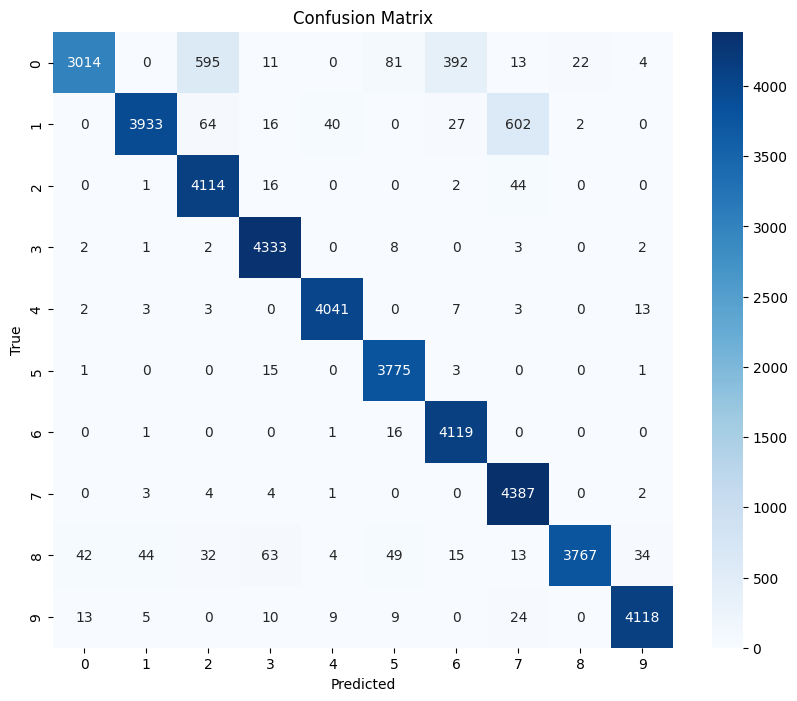

[[3014    0  595   11    0   81  392   13   22    4]
 [   0 3933   64   16   40    0   27  602    2    0]
 [   0    1 4114   16    0    0    2   44    0    0]
 [   2    1    2 4333    0    8    0    3    0    2]
 [   2    3    3    0 4041    0    7    3    0   13]
 [   1    0    0   15    0 3775    3    0    0    1]
 [   0    1    0    0    1   16 4119    0    0    0]
 [   0    3    4    4    1    0    0 4387    0    2]
 [  42   44   32   63    4   49   15   13 3767   34]
 [  13    5    0   10    9    9    0   24    0 4118]]


In [18]:
combined_loader = DataLoader(create_mnist_data([sum(class_splits)], 0, image_shape=image_shape), batch_size=batch_size)
inference(models, combined_loader, class_splits)
